# OCG598 HW1
## Abby Baskind
### Problem Description
#### Diffusion Equation
$$ 
\frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial x^2},\ 0 \le x \le 1
$$

#### Boundary Conditions

$$
u(0,t) = u(1,t) = 0,\ t \gt 0
$$

#### Analytical Solution

$$
u(x,t) = e^{-k^2t}\sin{kx},\ k = \pi
$$

#### Initial Conditions

$$
u^0(0 \le x \le 0.5) = 2x \\
u^0(0.5 \le x \le 1) = 2-2x
$$

#### Numerical Solution
Forward difference in time and center difference is space

$$
u^{n+1}_j = u^n_j + \frac{\Delta t}{(\Delta x)^2}(u^n_{j+1} - 2u^n_j + u^n_{j-1})
$$

#### Recreate this
<img src="Picture1.png" width="500"/>


In [1]:
# Basic packages
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import pandas as pd
import math
import netCDF4 as nc

# DateTime packages
from matplotlib.dates import DateFormatter
from datetime import datetime, timedelta
import time
import matplotlib.dates as mdates

# Stats packages
import scipy
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import seaborn as sns

# Logistical packages
import requests
from importlib import reload
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText

In [181]:
# array of x values with dx = 0.05
X = np.linspace(0,1,21)

# array of time values with intervals of dt
t = []
dt = 0.0013
for k in range(0,101):
    t.append(dt*k)
t = np.asarray(t)

# storage array with dimensions corresponding to size(x) by size(t)
# the array is initialized with 0's that we will replace
fx = np.zeros((len(X),len(t)))

# loop through time values by index (which I called ti)
for ti in range(len(t)-1):
    
    # time value at working index
    T = t[ti]
    
    # loop through x values by index
    for xi in range(len(X)-1):
        
        # x value at working index
        x = X[xi]
        
        # this just verifies my dt and dx values
        dt = np.diff(t).mean()
        dx = np.diff(X).mean()
        
        # gamma is ∆t/∆x^2
        gamma = dt/(dx*dx)
        
        # INITIAL CONDITIONS
        # At time 0
        if T == 0:
            # If x is between 0 and 1/2
            if x <= 0.5:     # if T = 0, ti is 0
                fx[xi,ti] = 2 * x
            # If x is between 1/2 and 1
            else:
                fx[xi,ti] = 2 - 2 * x
        
        # we then solve for the next time step, which we are able to do because
        # we know fx(this x, current time), fx(next x, current time), etc
        # so we are solving for the next time step with info we calculated either in the previous loop
        # or with the initial conditions
        fx[xi, ti + 1] = fx[xi, ti] + gamma * (fx[xi + 1, ti] - 2 * fx[xi,ti] + fx[xi - 1, ti])
    
FX = fx[:-1, :-1]

In [182]:
X = np.linspace(0,1,21)

t = []
dt = 0.0012
for k in range(0,101):
    t.append(dt*k)
t = np.asarray(t)

gx = np.zeros((len(X),len(t)))

for ti in range(len(t)-1):
    T = t[ti]
    for xi in range(len(X)-1):
        x = X[xi]
        dt = np.diff(t).mean()
        dx = np.diff(X).mean()
        gamma = dt/(dx*dx)
        # At time 0
        if T == 0:
            # If x is between 0 and 1/2
            if x <= 0.5:
                gx[xi,ti] = 2 * x
            # If x is between 1/2 and 1
            else:
                gx[xi,ti] = 2 - 2 * x
               
        gx[xi, ti + 1] = gx[xi, ti] + gamma * (gx[xi + 1, ti] - 2 * gx[xi,ti] + gx[xi - 1, ti])

GX = gx[:-1, :-1]

In [210]:
X = np.linspace(0,1,21)

t = []
dt = 0.00125
for k in range(0,101):
    t.append(dt*k)
t = np.asarray(t)

ux = np.zeros((len(X),len(t)))

for ti in range(len(t)):
    T = t[ti]
    for xi in range(len(X)):
        x = X[xi]
        k = np.pi
        ux[xi,ti] = (np.exp(-k**2*t[ti])*np.sin(k*X[xi]))
UX = ux[:-1, :-1]

Text(0.5, 0.98, 'Explicit Differentiation')

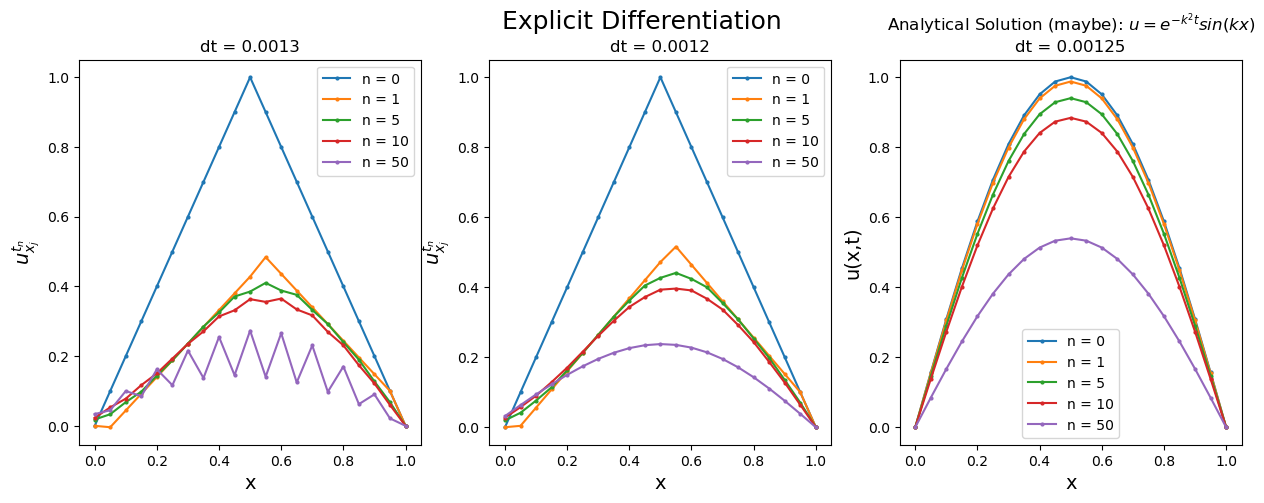

In [211]:
fig, axarr = plt.subplots(ncols = 3, figsize = [15,5])
axarr = axarr.flatten()

ax = axarr[0]
ax.plot(X, fx[:,0], label = 'n = 0', marker = 'o', ms = 2)
ax.plot(X, fx[:,1], label = 'n = 1', marker = 'o', ms = 2)
ax.plot(X, fx[:,5], label = 'n = 5', marker = 'o', ms = 2)
ax.plot(X, fx[:,10], label = 'n = 10', marker = 'o', ms = 2)
ax.plot(X, fx[:,50], label = 'n = 50', marker = 'o', ms = 2)
ax.legend()
ax.set_title('dt = 0.0013')
ax.set_ylabel(r'$u_{x_j}^{t_n}$', fontsize = 14)

ax = axarr[1]
ax.plot(X, gx[:,0], label = 'n = 0', marker = 'o', ms = 2)
ax.plot(X, gx[:,1], label = 'n = 1', marker = 'o', ms = 2)
ax.plot(X, gx[:,5], label = 'n = 5', marker = 'o', ms = 2)
ax.plot(X, gx[:,10], label = 'n = 10', marker = 'o', ms = 2)
ax.plot(X, gx[:,50], label = 'n = 50', marker = 'o', ms = 2)
ax.legend()
ax.set_title('dt = 0.0012')
ax.set_ylabel(r'$u_{x_j}^{t_n}$', fontsize = 14)

ax = axarr[2]
ax.plot(X, ux[:,0], label = 'n = 0', marker = 'o', ms = 2)
ax.plot(X, ux[:,1], label = 'n = 1', marker = 'o', ms = 2)
ax.plot(X, ux[:,5], label = 'n = 5', marker = 'o', ms = 2)
ax.plot(X, ux[:,10], label = 'n = 10', marker = 'o', ms = 2)
ax.plot(X, ux[:,50], label = 'n = 50', marker = 'o', ms = 2)
ax.legend()
ax.set_title('Analytical Solution (maybe): $u = e^{-k^2t}sin(kx)$\ndt = 0.00125')
ax.set_ylabel('u(x,t)', fontsize = 14)

for ax in axarr:
    ax.set_xlabel('x', fontsize = 14)
    
fig.suptitle('Explicit Differentiation', fontsize = 18)